# 1. Install PIP's

In [1]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 3. Load Data

In [3]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [56]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [57]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [58]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

In [59]:
full_df['review_comment_title'] = full_df['review_comment_title'].fillna('').astype(str)
full_df['review_comment_message'] = full_df['review_comment_title'].str.cat(full_df['review_comment_message'], sep=' ')

### 4.5. Drop Duplicates and NA

In [60]:
full_df = full_df.drop_duplicates(subset=['review_id'])
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

In [61]:
full_df

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng
0,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito boa a loja Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727
448,359d03e676b3c069f62cadba8dd3f6e8,5,,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299
620,e07549ef5311abcc92ba1784b093fb56,2,,fiquei triste por n ter me atendido.,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111
1468,15898b543726a832d4137fbef5d1d00e,1,,Aguardando retorno da loja,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869
...,...,...,...,...,...,...,...,...,...
16233547,ede62474f1618961be12678f362dca4a,5,,Otimo comprar por este site as mercadorias chegam antes do prazo determinado.,2017-11-11,2017-11-15 09:54:14,595fac2a385ac33a80bd5114aec74eb8,-23.660332,-46.528203
16233702,8ea780895f362ce949029f95b7181ff0,1,,"Ele não é um mini cajon, é um shaker, ou seja, um chocalho que imita o cajon. Péssimo.",2018-01-19,2018-01-21 02:51:39,3d2c44374ee42b3003a470f3e937a2ea,-26.491731,-49.075623
16234495,29bb71b2760d0f876dfa178a76bc4734,4,,So uma peça que veio rachado mas tudo bem rs,2018-03-01,2018-03-02 17:50:01,f1d4ce8c6dd66c47bbaa8c6781c2a923,-21.935321,-50.497562
16234587,371579771219f6db2d830d50805977bb,5,,Foi entregue antes do prazo.,2017-09-22,2017-09-22 23:10:57,b80910977a37536adeddd63663f916ad,-23.551013,-46.448489


### 4.6. Conversion Column Message in Lower Case

In [62]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.lower()

### 4.7. Removing Punctuation, Exemple (".", "!")

In [63]:
punct = string.punctuation
punct = punct.replace("'","")
full_df['review_comment_message'] = full_df['review_comment_message'].str.translate(str.maketrans(" "," ",punct))

### 4.8. Space removed at the beginning and end of the message

In [64]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.strip()

### 4.9. Removing Emoji

In [65]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte e símbolos de mapa
                           u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: emoji_pattern.sub(r'', x))

### 4.10. Removing Sites and Blogs

In [66]:
http = r"http\S+|www\.\S+"
pattern = re.compile(r"({})".format(http))
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: pattern.sub(r'', x))

### 4.11. Removing Accentuation

In [67]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: unidecode(x))

In [69]:
nlp = spacy.load('pt_core_news_lg')
def filtrar_tokens(texto):
    doc = nlp(texto)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.text.lower() == 'nada':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

full_df['review_comment_message'] = full_df['review_comment_message'].apply(filtrar_tokens)

### 4.12. Lematization

In [70]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

### 4.13. Remove Numbers

In [71]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\d+', '', x))

### 4.4. Remove Space Blank Excessive and Remove Broke Line

In [72]:
full_df['review_comment_message'] = full_df['review_comment_message'].str.replace('\n', ' ')
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
full_df = full_df[full_df['review_comment_message'].str.strip() != '']
full_df = full_df[~full_df['review_comment_message'].str.contains('nan')]

### 4.14. Join Word "Nao" with Next Word

In [36]:
full_df['review_comment_message'] = full_df['review_comment_message'].apply(lambda x: re.sub(r'nao\s+(\w+)', r'nao\1', x))

In [73]:
full_df.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng
0,a54f0611adc9ed256b57ede6b6eb5114,4,,nao testar produto ainda vir correto bom condicoes apenas caixa vir bem amassar danificar ficar chato tratar presente,2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,muito bom loja muito bom produto,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727
448,359d03e676b3c069f62cadba8dd3f6e8,5,,produto exatamente esperar descrito site chegar bem antes data prever,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299
620,e07549ef5311abcc92ba1784b093fb56,2,,fiquei triste n atendir,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111
1468,15898b543726a832d4137fbef5d1d00e,1,,aguardar retorno lojar,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869


# 5. Previus Analyze

In [96]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,39901,a54f0611adc9ed256b57ede6b6eb5114,15.28
1,review_score,int64,0,5,4,1.90
2,review_comment_title,object,30243,4064,NaN,10.00
3,review_comment_message,object,0,31363,testar produto ainda vir correto bom condicoe apenas caixa vir bem amassar danificar ficarar chato tratar presente,14.03
4,review_creation_date,object,0,618,2017-10-11 00:00:00,8.78
5,review_answer_timestamp,object,0,39875,2017-10-12 03:43:48,15.28
6,product_id,object,0,17919,87285b34884572647811a353c7ac498a,13.17
7,geolocation_lat,float64,0,1891,-23.680114,8.82
8,geolocation_lng,float64,0,1891,-46.452454,8.82


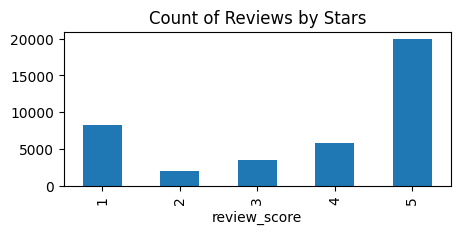

In [186]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [187]:
example = full_df['review_comment_message'].iloc[4]
print(example)

aguardar retorno loja


# 6. Training Model

### 6.1. Separeting Dataframe Training and Dataframe Test After Training

In [74]:
# Amostra os dados para df_train
df_train = full_df.sample(frac=0.95, random_state=45, ignore_index=True)

# Seleciona as linhas que não estão presentes em df_train para df_remaining
df_remaining = full_df.loc[~full_df.index.isin(df_train.index)].reset_index(drop=True)

### 6.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [75]:
df_train['sentiment'] = df_train['review_score'].apply(lambda x: 0 if x in [1,2,3] else 1)

In [76]:
df_train.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,sentiment
0,8d4ad3ae45ef7ed15ebf3d24dabf1f86,4,,entregar entregar dentro prazo,2017-08-25,2017-08-27 12:40:49,7fab1a1472fdd934397068931f63f3ca,-23.207064,-46.760735,1
1,607957a0a16be63148e7e51fc2b7c1a5,1,,poder bom entregar residenciar enfrentar tremenda fila retirar correio,2017-02-25,2017-02-28 01:38:38,52c80cedd4e90108bf4fa6a206ef6b03,-20.944706,-45.827098,0
2,499b0820814f9e7d1f7f50eb4d4bacfd,5,super recomendo,super recomendo chegar antes prazo,2018-08-23,2018-08-27 14:01:19,72ba1b1e37ca92467fe787728625c76a,-23.626053,-46.554888,1
3,e6571cc9b14378cc7a8cb904587e33cf,1,?!?,chegar central multimidiar ser comprar,2018-07-04,2018-07-05 08:59:59,5fde2352cd9bb03105487d89242a0549,-23.484915,-46.431503,0
4,29255d7dbc4189970c11c89f01a0e7e2,1,,bom noite comprar pendente amarelo recebi preto pedi devolucao agora nada,2017-09-05,2017-09-12 00:31:48,53759a2ecddad2bb87a079a1f1519f73,-20.802436,-49.395624,0


### 6.3. Selecting Columns Necessary for Training

In [77]:
selected_columns = ['review_comment_message', 'sentiment']
df_classification = df_train.loc[:, selected_columns]

In [78]:
df_classification.head(5)

,review_comment_message,sentiment
0,entregar entregar dentro prazo,1
1,poder bom entregar residenciar enfrentar tremenda fila retirar correio,0
2,super recomendo chegar antes prazo,1
3,chegar central multimidiar ser comprar,0
4,bom noite comprar pendente amarelo recebi preto pedi devolucao agora nada,0


### 6.4. Divising Dataframe Between Train and Test

In [79]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['review_comment_message'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 6.5. Inicializing Training IA

In [80]:
vectorizer = TfidfVectorizer()

In [81]:
ctmTr = vectorizer.fit_transform(comment_train)
comment_test_dtm = vectorizer.transform(comment_test)

In [82]:
smote = SMOTE(random_state=42)
ctmTr_resampled, sentiment_train_resampled = smote.fit_resample(ctmTr, sentiment_train)

In [83]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [84]:
normalization.fit(ctmTr_resampled)
X = normalization.transform(ctmTr_resampled)

In [128]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(32,16,16,1),
                                   activation='relu',
                                   solver='adam',
                                   learning_rate='constant',
                                   max_iter=100,
                                   early_stopping=True,
                                   n_iter_no_change=10,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train_resampled)

Iteration 1, loss = 0.62245075
Validation score: 0.874428
Iteration 2, loss = 0.43734800
Validation score: 0.890696
Iteration 3, loss = 0.37219068
Validation score: 0.892222
Iteration 4, loss = 0.33402018
Validation score: 0.894509
Iteration 5, loss = 0.30638834
Validation score: 0.896289
Iteration 6, loss = 0.28593970
Validation score: 0.896543
Iteration 7, loss = 0.26730104
Validation score: 0.899339
Iteration 8, loss = 0.25250668
Validation score: 0.900102
Iteration 9, loss = 0.24072635
Validation score: 0.900356
Iteration 10, loss = 0.22961479
Validation score: 0.899339
Iteration 11, loss = 0.22051470
Validation score: 0.898322
Iteration 12, loss = 0.21278692
Validation score: 0.898577
Iteration 13, loss = 0.20576611
Validation score: 0.896543
Iteration 14, loss = 0.19961576
Validation score: 0.899593
Iteration 15, loss = 0.19361246
Validation score: 0.901118
Iteration 16, loss = 0.18947348
Validation score: 0.898322
Iteration 17, loss = 0.18420383
Validation score: 0.899847
Iterat

# 7. Analyze Performance IA

### 7.1. Score

In [129]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8608048877672998

### 7.2. Graph Loss During Training

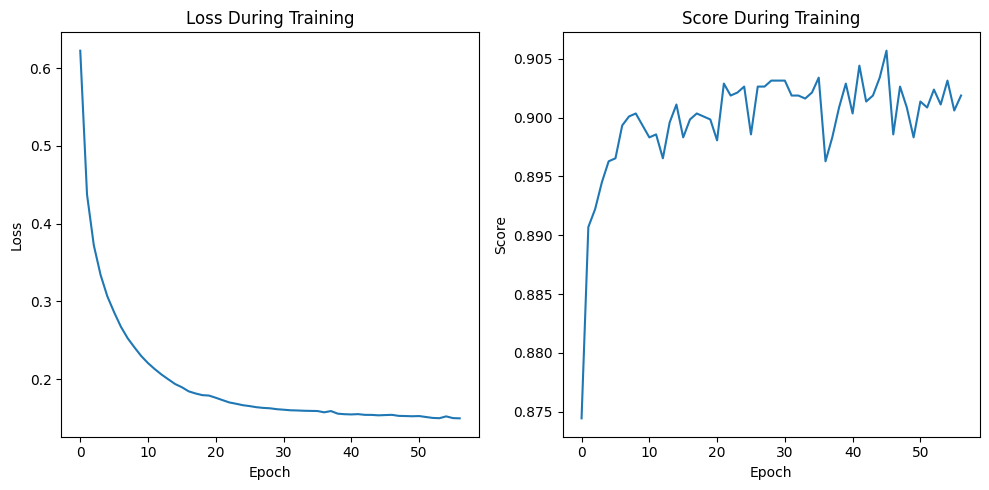

In [130]:
plt.figure(figsize=(10, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.validation_scores_)
plt.title('Score During Training')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

### 7.3. Confusion Matrix

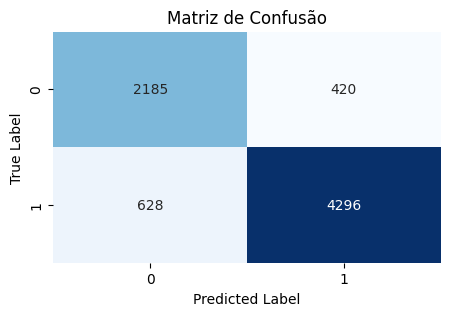

In [131]:
# Fazer previsões no conjunto de teste
predictions = analyze_sentiment.predict(X_test)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(sentiment_test, predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 7.4. Curve ROC

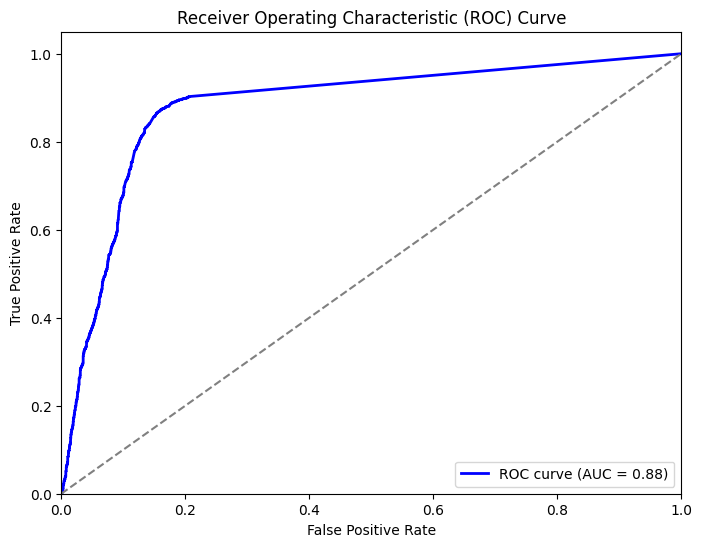

In [132]:
# Calcular as probabilidades previstas para a classe positiva
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

# Calcular a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 8. Test and Deploy IA

In [133]:
# Ajustar configurações para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

texto_teste_vetorizado = vectorizer.transform(df_remaining['review_comment_message'])
texto_teste_normalizado = normalization.transform(texto_teste_vetorizado)
sentimento_predito = analyze_sentiment.predict(texto_teste_normalizado)

df_remaining['sentimento_predito'] = sentimento_predito

df_remaining['sentimento_predito'] = df_remaining['sentimento_predito'].replace({0: 'negativo', 1: 'positivo'})

print(df_remaining[['review_comment_message', 'review_score', 'sentimento_predito']])

df_remaining[['review_id','review_comment_message', 'review_score', 'sentimento_predito']].to_csv('dados_processados.csv', index=False)


                                                                                    review_comment_message  \
0                                                                                     entregar antes prazo   
1      caneta crown satisfeito receber bem antes prazo estimar falta testalo nao acompanhar cartucho tinta   
2                                                      otimo produto gostar comprar ficar muito legal moto   
3                                                                                          bom atendimento   
4                                          otimo indico produto alto qualidade recebi antes prazo combinar   
...                                                                                                    ...   
39527                                         otimar comprar site mercadoria chegar antes prazo determinar   
39528                                                  nao mini Cajon Shaker Chocalho imitar cajon pessimo   
39529     

In [77]:
from collections import Counter

# Filtrar mensagens positivas e negativas
mensagens_positivas = df_remaining[df_remaining['sentimento_predito'] == 'positivo']['review_comment_message']
mensagens_negativas = df_remaining[df_remaining['sentimento_predito'] == 'negativo']['review_comment_message']

# Função para contar palavras mais comuns
def contar_palavras(mensagens):
    todas_mensagens = ' '.join(mensagens)
    palavras = todas_mensagens.split()
    contagem_palavras = Counter(palavras)
    return contagem_palavras.most_common(10)

# Contar palavras mais comuns para mensagens positivas
print("Palavras mais comuns em mensagens positivas:")
print(contar_palavras(mensagens_positivas))

# Contar palavras mais comuns para mensagens negativas
print("\nPalavras mais comuns em mensagens negativas:")
print(contar_palavras(mensagens_negativas))

KeyError: 'sentimento_predito'

## division

In [ ]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Criar o modelo MLPClassifier
mlp = MLPClassifier(max_iter=100)

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinar o modelo usando a pesquisa em grade
grid_search.fit(X, sentiment_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o desempenho do modelo
print("Acurácia da melhor configuração no conjunto de validação:")
print(grid_search.best_score_)